In [1]:
import os, getpass
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

In [2]:
import os
from dotenv import load_dotenv
from typing import List

from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import google.generativeai as genai

# Load API key
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Initialize Chroma and embedding
embedding_function = SentenceTransformerEmbeddingFunction()
chroma_client = chromadb.PersistentClient(path="./chroma_db")
collection_name = "Fynxt_database"

# Check if collection exists or create new
try:
    chroma_collection = chroma_client.get_collection(collection_name, embedding_function=embedding_function)
except:
    chroma_collection = chroma_client.create_collection(collection_name, embedding_function=embedding_function)

# Text wrapping utility (optional for CLI)
def word_wrap(text, width=100):
    import textwrap
    return "\n".join(textwrap.wrap(text, width))


g:\Fyxt_CS\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Build knowledgebase (run once or if PDFs are updated)
def build_pdf_knowledgebase(pdf_paths: List[str]):
    all_text = []

    for path in pdf_paths:
        reader = PdfReader(path)
        text_content = [p.extract_text().strip() for p in reader.pages if p.extract_text()]
        all_text.extend(text_content)

    combined_text = '\n\n'.join(all_text)

    # Step 1: Character-level splitting
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=2000,
        chunk_overlap=200
    )
    character_chunks = character_splitter.split_text(combined_text)

    # Step 2: Token-level splitting
    token_splitter = SentenceTransformersTokenTextSplitter(tokens_per_chunk=256, chunk_overlap=20)
    token_chunks = []
    for text in character_chunks:
        token_chunks += token_splitter.split_text(text)

    # Filter short/empty chunks
    token_chunks = [chunk for chunk in token_chunks if len(chunk.strip()) > 30]

    # Store in ChromaDB
    ids = [str(i) for i in range(len(token_chunks))]
    metadatas = [{"source": f"{os.path.basename(path)}_chunk_{i}"} for i in range(len(token_chunks))]
    chroma_collection.add(ids=ids, documents=token_chunks, metadatas=metadatas)

    print(f"✅ Knowledgebase built with {len(token_chunks)} chunks.")

# Run once to build
build_pdf_knowledgebase(["G:/Fyxt_CS/Docs/Final_Doc.pdf"])

✅ Knowledgebase built with 8 chunks.


In [20]:
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import random

# Query function
@tool
def query_pdf_knowledgebase(query: str) -> str:
    """
    Answers a user's query based on pre-loaded documentation in ChromaDB.
    """
    model = genai.GenerativeModel("gemini-1.5-pro")
    results = chroma_collection.query(query_texts=[query], n_results=5)
    retrieved_documents = results['documents'][0]

    if not retrieved_documents:
        return "⚠️ No relevant information found."

    context = "\n\n".join([doc.strip() for doc in retrieved_documents])

    prompt = (
        "You are a helpful customer support assistant. Your users are asking questions about specific feature of the financial software."
        "Use only the provided content to answer accurately.\n\n"
        f"Question: {query}\n\n"
        f"Information:\n{context}"
    )

    response = model.generate_content(prompt)
    return response.text


# Updated ticket generation tool
@tool
def generate_support_ticket(chat_history: list[BaseMessage]) -> str:
    """
    Generates a support ticket when no relevant documentation is found.
    Summarizes the conversation to create the ticket.
    """
    model = genai.GenerativeModel("gemini-1.5-pro")

    full_convo = "\n".join(
        f"{msg.type.capitalize()}: {msg.content}" for msg in chat_history
    )

    summary_prompt = (
        "You are a support assistant. Summarize the user's issue clearly and concisely "
        "based on the following conversation:\n\n"
        f"{full_convo}\n\n"
        "Only summarize the issue (do not include greetings or confirmations)."
    )

    summary = model.generate_content(summary_prompt).text.strip()

    ticket_id = f"TICKET-{random.randint(1000, 9999)}"
    return (
        f"✅ Ticket created!\n\n"
        f"📄 **Ticket ID**: {ticket_id}\n"
        f"📝 **Issue**: {summary}\n"
        f"A customer support rep will follow up with you soon."
    )


In [37]:
import base64
from typing import List
from langchain.schema import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

tools = [query_pdf_knowledgebase, generate_support_ticket]

llm_with_tools = llm.bind_tools(tools)

In [41]:
from typing import TypedDict, Annotated, List, Any, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain.memory import ConversationBufferMemory

class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    memory: ConversationBufferMemory

# AgentState
def assistant(state: AgentState) -> AgentState:
    messages = state["messages"]
    memory = state["memory"]

    # Retrieve past conversation from memory (if available)
    history = []
    if memory:
        history = memory.load_memory_variables({}).get("chat_history", [])
        if isinstance(history, str):
            history = []  # fallback if memory is still warming up

    # Updated system prompt
    system_prompt = SystemMessage(content=(
    "You are a helpful customer support assistant. "
    "Always use the `query_pdf_knowledgebase` tool first to answer the user's question, "
    "based on the product documentation. "
    "If the tool returns 'No relevant information found', ask the user if they want to raise a ticket. "
    "If they say yes, call the `generate_support_ticket` tool with the full chat history. "
    "Never skip using the `query_pdf_knowledgebase` tool."
))

    full_messages = [system_prompt] + history + messages

    # Run the model with tools
    response = llm_with_tools.invoke(full_messages)

    # Save to memory
    if memory:
        memory.save_context({"input": messages[-1].content}, {"output": response.content})

    return {
        "messages": messages + [response],
        "memory": memory,
    }


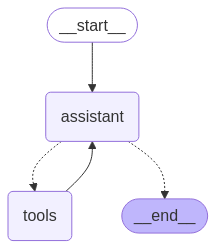

In [42]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile(name="CustomerSupportAgent")

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [43]:
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import messages_from_dict

memory = ConversationBufferMemory(return_messages=True,memory_key="history")

# Initial state
initial_state = {
    "messages": [HumanMessage(content="How can I enable or disable fee structures for PAMM?")],
    "memory": memory,
}

final_state = react_graph.invoke(initial_state)
final_state["messages"][-1].content

'I am sorry, I cannot find the answer to your question in the documentation. Would you like me to raise a support ticket for you?'

In [26]:
final_state

{'messages': [HumanMessage(content='How can I enable or disable fee structures for PAMM?', additional_kwargs={}, response_metadata={}, id='e5b389fa-0a05-4feb-8206-0e23debe7164'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'query_pdf_knowledgebase', 'arguments': '{"query": "enable or disable fee structures for PAMM"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-81c0eddb-864d-419d-a8e4-d3cef9d32d4e-0', tool_calls=[{'name': 'query_pdf_knowledgebase', 'args': {'query': 'enable or disable fee structures for PAMM'}, 'id': '3ed03a70-89e0-4a60-a84d-cf94f5268f3a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 154, 'output_tokens': 15, 'total_tokens': 169, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="Error: ResourceExhausted('You exceeded your current quota, please check your plan and billing details. For more information on this error, head to:

In [27]:
next_state = react_graph.invoke({
    "messages": [HumanMessage(content="I want to setup account for my MT4, how to do that?")],
    "memory": final_state["memory"],
})
next_state["messages"][-1].content

'I am sorry, I cannot find the answer to your question in the knowledge base. Would you like me to raise a support ticket for you?'

In [28]:
next_state

{'messages': [HumanMessage(content='I want to setup account for my MT4, how to do that?', additional_kwargs={}, response_metadata={}, id='6ef45663-c5ee-40b6-97ec-242197a2928b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'query_pdf_knowledgebase', 'arguments': '{"query": "setup account for MT4"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-54088564-e03e-4b51-a828-5e634d181e4f-0', tool_calls=[{'name': 'query_pdf_knowledgebase', 'args': {'query': 'setup account for MT4'}, 'id': 'd74afb04-89e0-499f-a63a-d14c66f1e624', 'type': 'tool_call'}], usage_metadata={'input_tokens': 157, 'output_tokens': 12, 'total_tokens': 169, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="Error: ResourceExhausted('You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/ra

In [29]:
next_state = react_graph.invoke({
    "messages": [HumanMessage(content="Yes, please generate the ticket")],
    "memory": final_state["memory"],
})
next_state["messages"][-1].content

'Can you please provide the original question, so I can generate the support ticket?'

In [30]:
next_state

{'messages': [HumanMessage(content='Yes, please generate the ticket', additional_kwargs={}, response_metadata={}, id='e1a1bfc9-a98b-43af-8c01-ef79ef7ec3f8'),
  AIMessage(content='Can you please provide the original question, so I can generate the support ticket?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-315492d0-8274-4ec2-82aa-1763d043e643-0', usage_metadata={'input_tokens': 148, 'output_tokens': 17, 'total_tokens': 165, 'input_token_details': {'cache_read': 0}})],
 'memory': ConversationBufferMemory(chat_memory=InMemoryChatMessageHistory(messages=[HumanMessage(content='How can I enable or disable fee structures for PAMM?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={}), HumanMessage(content="Error: ResourceExhausted('You exceeded your current quota, please check your plan and billing details. For more inf

In [31]:
final_state["memory"].chat_memory.messages

[HumanMessage(content='How can I enable or disable fee structures for PAMM?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Error: ResourceExhausted('You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.')\n Please fix your mistakes.", additional_kwargs={}, response_metadata={}),
 AIMessage(content='I am sorry, I cannot find the answer to your question in the knowledge base. Would you like me to create a support ticket for you?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I want to setup account for my MT4, how to do that?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Error: ResourceExhausted('You exceeded your current quota, please check your plan and billing detai

In [32]:
next_state = react_graph.invoke({
    "messages": [HumanMessage(content="my name is krunal")],
    "memory": final_state["memory"],
})
next_state["messages"][-1].content

'Okay Krunal, how can I help you today?'

In [33]:
next_state = react_graph.invoke({
    "messages": [HumanMessage(content="I live in surat")],
    "memory": final_state["memory"],
})
next_state["messages"][-1].content

'I am sorry, I cannot help you with that request. I can only answer questions based on the pre-loaded documentation. Would you like to raise a ticket?'

In [34]:
next_state = react_graph.invoke({
    "messages": [HumanMessage(content="Im from india and its summar going on here")],
    "memory": final_state["memory"],
})
next_state["messages"][-1].content

"I don't have enough information to answer your question. Would you like me to create a support ticket?"

In [35]:
next_state = react_graph.invoke({
    "messages": [HumanMessage(content="Do know my name?")],
    "memory": final_state["memory"],
})
next_state["messages"][-1].content

"I do not have access to your personal information, so I don't know your name."

In [36]:
final_state["memory"].chat_memory.messages

[HumanMessage(content='How can I enable or disable fee structures for PAMM?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Error: ResourceExhausted('You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.')\n Please fix your mistakes.", additional_kwargs={}, response_metadata={}),
 AIMessage(content='I am sorry, I cannot find the answer to your question in the knowledge base. Would you like me to create a support ticket for you?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I want to setup account for my MT4, how to do that?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Error: ResourceExhausted('You exceeded your current quota, please check your plan and billing detai